# NDIS v1.0 - Processed Using Decision Tree Algorithm

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

In [ ]:
%matplotlib inline
# basic packages
import csv
import numpy as np
import os
import timeit
import random
import string
from playsound import playsound

# Data management
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point  # to get points from long lat

# Request service
#from requests import Request
import json
import re
from functools import reduce
#from owslib.wfs import WebFeatureService

# Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

## Select Valuable Input Features

In [ ]:
# Set the path to this geodatabase
gdb_path = r"D:\ArcGISProjects\GeohazardDB\GeohazardDB.gdb"  # This gdb path

### Load Datasets

In [ ]:
# Import Database/Dataset
# Specify the feature class name
ghz_clean = "cleaned_geohazard_data"  # Geohazard feature class
ghz_clean_path = f"{gdb_path}\\{ghz_clean}"

# Use arcpy to create a list of fields
ghz_clean_fields = [f.name for f in arcpy.ListFields(f"{gdb_path}\\{ghz_clean}")]

# Use arcpy to create a search cursor and load the data into a list of dictionaries
ghz_clean_data = []
with arcpy.da.SearchCursor(f"{gdb_path}\\{ghz_clean}", ghz_clean_fields) as cursor:
    for row in cursor:
        ghz_clean_data.append(dict(zip(ghz_clean_fields, row)))

# Convert the list of dictionaries into a DataFrame
ghz_celan_df = pd.DataFrame(ghz_clean_data)
ghz_celan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814699 entries, 0 to 1814698
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   OBJECTID    int64  
 1   Shape       object 
 2   HazardID    float64
 3   latitude    float64
 4   longitude   float64
 5   HazardType  int64  
 6   distance    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 96.9+ MB


In [ ]:
# Convert the DataFrame to a CSV file
ghz_celan_df.to_csv(r"D:\NDIS_Database\ghz_processed.csv", index=False)

In [ ]:
# Filter the dataset to include only distances <= 500 km (500,000 m)
filtered_geohazard = ghz_celan_df[ghz_celan_df["distance"] <= 1046000]

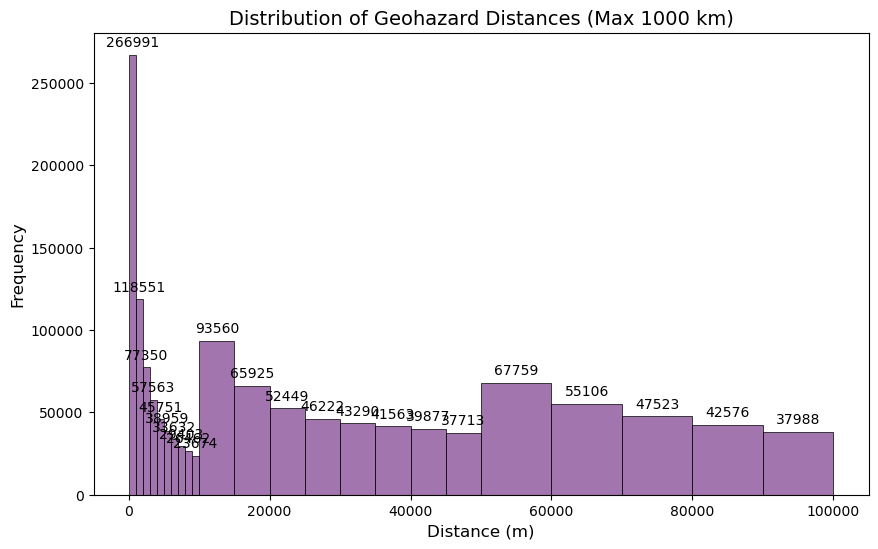

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
ax = fig.gca()

# Set the color scheme to purple-green
sns.set_palette("PRGn")

# Define adjusted bin edges: finer resolution for small distances, coarser for large ones
adjusted_bins = np.concatenate([
    np.arange(0, 10000, 1000),  # 0 - 10 km: 1 km bins
    np.arange(10000, 50000, 5000),  # 10 - 50 km: 5 km bins
    np.arange(50000, 100000, 10000),  # 50 - 100 km: 10 km bins
    np.arange(100000, 1046000, 1046000)  # 100 - 500 km: 50 km bins
])

ax = sns.histplot(filtered_geohazard["distance"], bins=adjusted_bins, kde=False, edgecolor="black")

# Customize the plot
plt.xlabel("Distance (m)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Geohazard Distances (Max 1000 km)", fontsize=14)
plt.grid(False)

# Format x and y axis labels to avoid scientific notation
ax.ticklabel_format(style='plain', axis='x')
ax.ticklabel_format(style='plain', axis='y')

# Label each bar with frequency count
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 5000,
                 f"{int(height)}", ha='center', fontsize=10, color="black")

# Show the plot
# Save the plot as PNG with transparent background
fig.savefig('D:/NDIS_Database/FE_Display/distance_dist.png', transparent=True)
plt.show()

### Pre-Processing With RPAS and Sensor Dataset

In [ ]:
# By Max Payload
dc = drone_cleaned.distance_range.unique()
dc

array([1.50000e+05, 4.00000e+03, 1.00000e+04, 1.80000e+04, 7.00000e+03,
       2.00000e+03, 1.50000e+04, 8.00000e+03, 5.00000e+03, 1.00000e+03,
       1.60000e+04, 3.50000e+04, 1.20000e+04, 2.00000e+04, 7.00000e+02,
       1.35000e+05, 5.00000e+04, 2.10000e+01, 2.40000e+04, 3.00000e+02,
       4.50000e+05, 3.00000e+04, 2.70000e+04, 1.04600e+06, 5.63000e+05,
       1.04607e+05, 5.25000e+04, 4.00000e+04, 3.02400e+04, 4.50000e+04,
       1.90000e+05, 3.00000e+03, 8.60000e+04])

In [ ]:
# Given range values
range_values = np.array([
    1.50000e+05, 4.00000e+03, 1.00000e+04, 1.80000e+04, 7.00000e+03,
    2.00000e+03, 1.50000e+04, 8.00000e+03, 5.00000e+03, 1.00000e+03,
    1.60000e+04, 3.50000e+04, 1.20000e+04, 2.00000e+04, 7.00000e+02,
    1.35000e+05, 5.00000e+04, 2.10000e+01, 2.40000e+04, 3.00000e+02,
    4.50000e+05, 3.00000e+04, 2.70000e+04, 1.04600e+06, 5.63000e+05,
    1.04607e+05, 5.25000e+04, 4.00000e+04, 3.02400e+04, 4.50000e+04,
    1.90000e+05, 3.00000e+03, 8.60000e+04
])

# Determine min and max for binning
min_value = range_values.min()
max_value = range_values.max()

# Create 10 optimized bins using log spacing (to handle large range variation)
bins = np.logspace(np.log10(min_value), np.log10(max_value), num=11)

# Display the bins
bins

array([2.10000000e+01, 6.19370525e+01, 1.82676117e+02, 5.38781918e+02,
       1.58907447e+03, 4.68678995e+03, 1.38231407e+04, 4.07697424e+04,
       1.20245604e+05, 3.54650393e+05, 1.04600000e+06])

In [ ]:
# Load Drone and Sensor data
drone_data = pd.read_csv("D:/NDIS_Database/rpas_nonan.csv") # Shortlisted verison of RPAS gdb with no NaN data on distance
sensor_data = pd.read_csv("D:/NDIS_Database/sensor.csv") # Geophysical sensor list

# Display the first few rows to verify
drone_data
sensor_data

## Defining Rules for Selection

In [ ]:
sample_data = pd.read_csv("D:/NDIS_Database/sample_data.csv")
sample_data

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance
0,1307494,"(-177.31669999999997, -29.88089999999994)",606937635,-29.880900,-177.316700,1,9.431814e+05
1,968613,"(36.53950000000003, 37.67920000000004)",15137777,37.679200,36.539500,2,1.233977e+03
2,1769614,"(173.54381703900003, 51.55417642400005)",1777184379,51.554176,173.543817,3,1.364629e+06
3,1303675,"(-71.29579999999999, -27.432099999999934)",606930780,-27.432100,-71.295800,4,3.639637e+04
4,421094,"(-91.97299999999996, 15.38190000000003)",979512,15.381900,-91.973000,5,6.125551e+02
5,1617256,"(112.82000000000005, -9.46999999999997)",618097240,-9.470000,112.820000,1,1.155234e+05
6,359312,"(169.2500000000001, -20.249999999999943)",824954,-20.250000,169.250000,2,5.552423e+04
7,404479,"(137.54000000000008, 35.85000000000008)",949160,35.850000,137.540000,5,1.753875e+02
8,1392984,"(126.54800000000012, 9.120000000000061)",609760535,9.120000,126.548000,5,3.344343e+04
9,1768000,"(62.645375096000066, 26.48610059500004)",1777032897,26.486101,62.645375,4,1.169089e+04


---

In [ ]:
# Load the datasets
geohazard_df = ghz_celan_df.copy()
drone_df     = drone_data.copy()
sensor_df    = sensor_data.copy()

### Sensor Selection

In [ ]:
# Step 1: Sensor Selection (Updated with GPR priority for Landslide)
def select_best_sensor(hazard_type, distance):
    if hazard_type in [1, 3, 4, 5]:  # Volcano, Tsunami, Fault, Earthquake
        matching_sensors = sensor_df[sensor_df["sensor_name"] == "Seismic"]
    elif hazard_type == 2:  # Landslide (prioritize GPR)
        matching_sensors = sensor_df[sensor_df["sensor_name"] == "GPR"]
        if matching_sensors.empty:  # If no GPR, fallback to Magnetometer
            matching_sensors = sensor_df[sensor_df["sensor_name"] == "Lidar"]
    else:
        return "No suitable sensor found"

    # If multiple sensors qualify, apply additional filtering
    if len(matching_sensors) > 1:
        if hazard_type in [4, 5]:  # Fault, Earthquake (Underground hazards)
            best_sensor = matching_sensors.loc[matching_sensors["sensor_weight"].idxmax()]
        elif hazard_type in [1, 3]:  # Volcano, Tsunami (Surface hazards)
            best_sensor = matching_sensors.loc[matching_sensors["sensor_weight"].idxmin()]
        elif hazard_type == 2:  # Landslide (Check distance to prefer lighter sensors if far)
            if distance > 200:
                best_sensor = matching_sensors.loc[matching_sensors["sensor_weight"].idxmin()]
            else:
                best_sensor = matching_sensors.loc[matching_sensors["sensor_weight"].idxmax()]
        else:
            best_sensor = matching_sensors.iloc[0]
    elif len(matching_sensors) == 1:
        best_sensor = matching_sensors.iloc[0]
    else:
        return "No suitable sensor found"

    return best_sensor["sensor_name"]

# Apply sensor selection to dataset
geohazard_df["selected_sensor"] = geohazard_df.apply(lambda row: select_best_sensor(row["HazardType"], row["distance"]), axis=1)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,GPR
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic
...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic


In [ ]:
# Step 2: Drone Selection (Updated matching logic with ±50% tolerance & special rule for large distances)
def select_best_drone(hazard_type, hazard_distance):
    # Step 1: Find exact matches
    matching_drones = drone_df[drone_df["distance_range"] == hazard_distance]

    # Step 2: If no exact match, find drones within ±50% of hazard distance (only if < 70,000)
    if matching_drones.empty and hazard_distance < 70000:
        lower_bound = hazard_distance * 0.5
        upper_bound = hazard_distance * 1.5
        matching_drones = drone_df[(drone_df["distance_range"] >= lower_bound) & (drone_df["distance_range"] <= upper_bound)]

    # Step 3: For large distances (> 70,000), match with the next available `distance_range`
    if matching_drones.empty and hazard_distance >= 70000:
        sorted_drones = drone_df.sort_values("distance_range")
        next_distance = sorted_drones[sorted_drones["distance_range"] > hazard_distance]["distance_range"].min()
        matching_drones = sorted_drones[sorted_drones["distance_range"] == next_distance]

    # Step 4: Apply hierarchical selection if multiple drones qualify
    if len(matching_drones) > 1:
        if hazard_type in [1, 3]:  # Volcano, Tsunami → Min Flight Time
            best_drone = matching_drones.loc[matching_drones["flight_time"].idxmin()]
        elif hazard_type in [2, 4, 5]:  # Landslide, Fault, Earthquake → Max Flight Time
            best_drone = matching_drones.loc[matching_drones["flight_time"].idxmax()]
        else:
            best_drone = matching_drones.iloc[0]
    elif len(matching_drones) == 1:
        best_drone = matching_drones.iloc[0]
    else:
        return "No suitable drone found"

    return best_drone["mfc_model"]

# Apply drone selection to dataset
geohazard_df["selected_drone"] = geohazard_df.apply(lambda row: select_best_drone(row["HazardType"], row["distance"]), axis=1)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,selected_drone
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR,No suitable drone found
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR,No suitable drone found
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,GPR,HG Robotics VETAL
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR,Autel Robotics EVO II Dual 640T RTK Rugged Bundle
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic,No suitable drone found
...,...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic,JOUAV CW-15
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic,JOUAV CW-15
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic,Zhuoyi Droneeye TS-A12
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic,IDEAFLY Poseidon-480 Pro II


In [ ]:
# Apply the function to each row in the geohazard dataset
sample_data["selected_drone"] = sample_data.apply(lambda row: select_best_drone(row["HazardType"], row["distance"]), axis=1)

# Display the final geohazard dataset with selected drones
sample_data

## Model Training Independent Approach

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Prepare features (X) and target variables (y)
X = geohazard_df[['HazardType', 'distance']].copy()  # Features for training
y_sensor = geohazard_df['selected_sensor']  # Target variable for sensor selection
y_drone = geohazard_df['selected_drone']  # Target variable for drone selection

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train_sensor, y_test_sensor = train_test_split(X, y_sensor, test_size=0.2, random_state=42)
X_train, X_test, y_train_drone, y_test_drone = train_test_split(X, y_drone, test_size=0.2, random_state=42)

# Train Decision Tree Classifiers
sensor_clf = DecisionTreeClassifier(random_state=42)
sensor_clf.fit(X_train, y_train_sensor)

drone_clf = DecisionTreeClassifier(random_state=42)
drone_clf.fit(X_train, y_train_drone)

# Predict on test set
y_pred_sensor = sensor_clf.predict(X_test)
y_pred_drone = drone_clf.predict(X_test)

# Evaluate model performance
sensor_accuracy = accuracy_score(y_test_sensor, y_pred_sensor)
drone_accuracy = accuracy_score(y_test_drone, y_pred_drone)

sensor_report = classification_report(y_test_sensor, y_pred_sensor)
drone_report = classification_report(y_test_drone, y_pred_drone)

sensor_accuracy, drone_accuracy, sensor_report, drone_report

(1.0,
 0.9999917341709373,
 '              precision    recall  f1-score   support\n\n         GPR       1.00      1.00      1.00      2856\n     Seismic       1.00      1.00      1.00    360084\n\n    accuracy                           1.00    362940\n   macro avg       1.00      1.00      1.00    362940\nweighted avg       1.00      1.00      1.00    362940\n',
 '                                                        precision    recall  f1-score   support\n\n                                         ACSL AirTruck       1.00      1.00      1.00      2329\n                                              ACSL Fi4       1.00      1.00      1.00      2733\nACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       1.00      1.00      1.00        40\n                           AEE Aviation Technology G10       1.00      1.00      1.00     19057\n                                 Acecore Noa H6 Hybrid       1.00      1.00      1.00      3602\n                                        Acecore 

In [ ]:
sensor_accuracy

1.0

In [ ]:
drone_accuracy

0.9999917341709373

In [ ]:
sensor_report

'              precision    recall  f1-score   support\n\n         GPR       1.00      1.00      1.00      2856\n     Seismic       1.00      1.00      1.00    360084\n\n    accuracy                           1.00    362940\n   macro avg       1.00      1.00      1.00    362940\nweighted avg       1.00      1.00      1.00    362940\n'

In [ ]:
drone_report

'                                                        precision    recall  f1-score   support\n\n                                         ACSL AirTruck       1.00      1.00      1.00      2329\n                                              ACSL Fi4       1.00      1.00      1.00      2733\nACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       1.00      1.00      1.00        40\n                           AEE Aviation Technology G10       1.00      1.00      1.00     19057\n                                 Acecore Noa H6 Hybrid       1.00      1.00      1.00      3602\n                                        Acecore Zoe X4       1.00      1.00      1.00     13591\n                    Aerosonde Ltd AAI Aerosonde Mk 4.3       1.00      1.00      1.00      6650\n     Autel Robotics EVO II Dual 640T RTK Rugged Bundle       1.00      1.00      1.00      3471\n                                          DJI AgrasT16       0.98      1.00      0.99        50\n                           

-----

## Model Training Combined Approach

### Define the Target Output and Decision Criteria (Splitting Conditions)

In [ ]:
# Load the datasets
geohazard_df = ghz_celan_df.copy() # for sample data change to sample_data for real process ghz_celan_df

### Feature Selection: Select Sensor

In [ ]:
# Step 1: Filter Drone Selection Based on Sensor Selection

# Function to select the best sensor based on hazard type and distance
def select_best_sensor_v3(hazard_type, distance):
    if hazard_type == 2:  # Landslide
        return "GPR" if distance <= 100 else "Lidar"
    else:
        return "Seismic"

In [ ]:
# Reapply the simplified sensor selection logic
geohazard_df["selected_sensor"] = geohazard_df.apply(lambda row: select_best_sensor_v3(row["HazardType"], row["distance"]), axis=1)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,Lidar
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic
...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic


### Define Target Output: Drone Selection

In [ ]:
# Step 2: Drone Selection Based on Sensor Selection

# Function to filter drones based on sensor selection
def filter_drones_by_sensor(sensor_name):
    if "Seismic" in sensor_name:
        return drone_df  # All drones are assumed compatible with seismic sensors
    elif "GPR" in sensor_name:
        return drone_df[drone_df["max_payload_weight"] >= 3500]  # GPR needs high payload drones
    elif "Lidar" in sensor_name:
        return drone_df[drone_df["max_payload_weight"] >= 900]  # Lidar needs medium payload drones
    else:
        return drone_df  # Default case, no filtering

# Apply filtering logic
geohazard_df["filtered_drones"] = geohazard_df["selected_sensor"].apply(filter_drones_by_sensor)

### Function to Select Drone

In [ ]:
# Function to select the best drone after filtering
def select_best_drone(hazard_type, hazard_distance, filtered_drones):
    if filtered_drones.empty:
        return "No suitable drone found"

    # Step 1: Find exact matches
    matching_drones = filtered_drones[filtered_drones["distance_range"] == hazard_distance]

    # Step 2: If no exact match, find drones within ±50% of hazard distance (only if < 70,000)
    if matching_drones.empty and hazard_distance < 70000:
        lower_bound = hazard_distance * 0.5
        upper_bound = hazard_distance * 1.5
        matching_drones = filtered_drones[
            (filtered_drones["distance_range"] >= lower_bound) & (filtered_drones["distance_range"] <= upper_bound)]

    # Step 3: For large distances (> 70,000), match with the next available `distance_range`
    if matching_drones.empty and hazard_distance >= 70000:
        sorted_drones = filtered_drones.sort_values("distance_range")
        next_distance = sorted_drones[sorted_drones["distance_range"] > hazard_distance]["distance_range"].min()
        matching_drones = sorted_drones[sorted_drones["distance_range"] == next_distance]

    # Step 4: Apply hierarchical selection if multiple drones qualify
    if len(matching_drones) > 1:
        if hazard_type in [1, 3]:  # Volcano, Tsunami → Min Flight Time
            best_drone = matching_drones.loc[matching_drones["flight_time"].idxmin()]
        elif hazard_type in [2, 4, 5]:  # Landslide, Fault, Earthquake → Max Flight Time
            best_drone = matching_drones.loc[matching_drones["flight_time"].idxmax()]
        else:
            best_drone = matching_drones.iloc[0]
    elif len(matching_drones) == 1:
        best_drone = matching_drones.iloc[0]
    else:
        return "No suitable drone found"

    return best_drone["mfc_model"]

In [ ]:
# Apply drone selection
geohazard_df["selected_drone"] = geohazard_df.apply(
    lambda row: select_best_drone(row["HazardType"], row["distance"], row["filtered_drones"]), axis=1
)

# Drop temporary 'filtered_drones' column to clean up dataset
geohazard_df.drop(columns=["filtered_drones"], inplace=True)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,selected_drone
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR,No suitable drone found
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR,No suitable drone found
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,GPR,Acecore Zoe X4
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR,No suitable drone found
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic,No suitable drone found
...,...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic,JOUAV CW-15
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic,JOUAV CW-15
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic,Zhuoyi Droneeye TS-A12
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic,IDEAFLY Poseidon-480 Pro II


In [ ]:
# Function to select the best drone based on geohazard distance and payload capacity
def select_best_drone_v2(hazard_distance, sensor_weight):
    # Step 1: Find drones with exact or closest distance match
    matching_drones = drone_df[drone_df["distance_range"] >= hazard_distance]

    # Step 2: If no drone exactly matches, find the next closest available distance
    if matching_drones.empty:
        next_distance = drone_df[drone_df["distance_range"] > hazard_distance]["distance_range"].min()
        matching_drones = drone_df[drone_df["distance_range"] == next_distance]

    # Step 3: Filter drones that can handle the sensor payload weight
    feasible_drones = matching_drones[matching_drones["max_payload_weight"] >= sensor_weight]

    # Step 4: If no drones can handle the payload, pick the next closest distance-range drone with a higher weight capacity
    if feasible_drones.empty:
        sorted_drones = drone_df[drone_df["distance_range"] > hazard_distance].sort_values("distance_range")
        for _, drone in sorted_drones.iterrows():
            if drone["max_payload_weight"] >= sensor_weight:
                return drone["mfc_model"]
        return "No suitable drone found"

    # Step 5: Select the best drone (lowest distance range that fits the payload)
    best_drone = feasible_drones.iloc[0]

    return best_drone["mfc_model"]

In [ ]:
# Apply drone selection based on refined logic
geohazard_df["selected_drone"] = geohazard_df.apply(
    lambda row: select_best_drone_v2(row["distance"], sensor_df[sensor_df["sensor_name"] == row["selected_sensor"]]["sensor_weight"].values[0] if row["selected_sensor"] in sensor_df["sensor_name"].values else 0),
    axis=1
)

geohazard_df

______
# Optimized Vectorized Filtering

In [ ]:
# Load the datasets
geohazard_df = ghz_celan_df.copy()
drone_df     = drone_data.copy()
sensor_df    = sensor_data.copy()
sensor_df

In [ ]:
# Load the datasets
geohazard_df = ghz_celan_df.copy() # for sample data change to sample_data for real process ghz_celan_df
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451
...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954


In [ ]:
# Step 1: Default all sensors to "Seismic"
geohazard_df["selected_sensor"] = "Seismic"

# Step 2: Assign "GPR" to Landslides with distance ≤ 100m
geohazard_df.loc[(geohazard_df["HazardType"] == 2) & (geohazard_df["distance"] <= 100), "selected_sensor"] = "GPR"

# Step 3: Assign "Lidar" to Landslides with distance > 100m
geohazard_df.loc[(geohazard_df["HazardType"] == 2) & (geohazard_df["distance"] > 100), "selected_sensor"] = "Lidar"

# Step 4: Merge with Sensor Data to get sensor properties
geohazard_df = geohazard_df.merge(sensor_df, left_on="selected_sensor", right_on="sensor_name", how="left")

geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,sensor_id,parameters,sensor_name,s_encoded,sensor_weight
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR,5,conductivity,GPR,5,3500
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR,5,conductivity,GPR,5,3500
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,Lidar,6,distance,Lidar,6,900
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR,5,conductivity,GPR,5,3500
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic,1,velocity,Seismic,1,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic,1,velocity,Seismic,1,1000
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic,1,velocity,Seismic,1,1000
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic,1,velocity,Seismic,1,1000
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic,1,velocity,Seismic,1,1000


In [ ]:
# Step 1: Precompute sorted drone dataset
drone_df_sorted = drone_df.sort_values(["distance_range", "max_payload_weight"])

# Step 2: Optimized drone selection function
def fast_select_drone_v2(geohazard_df, drone_df):
    geohazard_df = geohazard_df.copy()
    geohazard_df["selected_drone"] = None

    for index, row in geohazard_df.iterrows():
        hazard_distance = row["distance"]
        sensor_weight = sensor_df.loc[sensor_df["sensor_name"] == row["selected_sensor"], "sensor_weight"].values
        sensor_weight = sensor_weight[0] if len(sensor_weight) > 0 else 0

        # Step 1: Find the first drone that can handle short distances
        if hazard_distance < drone_df_sorted["distance_range"].min():
            matching_drones = drone_df_sorted  # Allow all drones for very short distances
        else:
            # Step 2: Select drones with matching or closest higher distance
            matching_drones = drone_df_sorted[drone_df_sorted["distance_range"] >= hazard_distance]

        # Step 3: Filter drones that can carry the sensor payload
        feasible_drones = matching_drones[matching_drones["max_payload_weight"] >= sensor_weight]

        # Step 4: If no direct match, select the **next available drone that can carry the payload**
        if feasible_drones.empty:
            sorted_drones = drone_df_sorted[drone_df_sorted["max_payload_weight"] >= sensor_weight]
            if not sorted_drones.empty:
                best_drone = sorted_drones.iloc[0]
            else:
                best_drone = None
        else:
            best_drone = feasible_drones.iloc[0]

        # Assign the best drone found
        geohazard_df.at[index, "selected_drone"] = best_drone["mfc_model"] if best_drone is not None else "No suitable drone found"

    return geohazard_df

# Apply the optimized selection
geohazard_df = fast_select_drone_v2(geohazard_df, drone_df)
geohazard_df

In [ ]:
# Precompute sorted drone dataset
drone_df_sorted = drone_df.sort_values(["distance_range", "max_payload_weight"])

# Optimized function for drone selection
def fast_select_drone_v3(geohazard_df, drone_df):
    geohazard_df = geohazard_df.copy()
    geohazard_df["selected_drone"] = None

    for index, row in geohazard_df.iterrows():
        hazard_distance = row["distance"]
        sensor_weight = sensor_df.loc[sensor_df["sensor_name"] == row["selected_sensor"], "sensor_weight"].values
        sensor_weight = sensor_weight[0] if len(sensor_weight) > 0 else 0

        # Step 1: Find exact matches
        matching_drones = drone_df_sorted[drone_df_sorted["distance_range"] == hazard_distance]

        # Step 2: If no exact match, find drones within ±50% of hazard distance (only if < 70,000)
        if matching_drones.empty and hazard_distance < 70000:
            lower_bound = hazard_distance * 0.5
            upper_bound = hazard_distance * 1.5
            matching_drones = drone_df_sorted[
                (drone_df_sorted["distance_range"] >= lower_bound) & (drone_df_sorted["distance_range"] <= upper_bound)
            ]

        # Step 3: For large distances (> 70,000), match with the next available `distance_range`
        if matching_drones.empty and hazard_distance >= 70000:
            sorted_drones = drone_df_sorted.sort_values("distance_range")
            next_distance = sorted_drones[sorted_drones["distance_range"] > hazard_distance]["distance_range"].min()
            matching_drones = sorted_drones[sorted_drones["distance_range"] == next_distance]

        # Step 4: Filter drones that can handle the sensor payload weight
        feasible_drones = matching_drones[matching_drones["max_payload_weight"] >= sensor_weight]

        # Step 5: If no feasible drones found, select the **next closest drone that can carry the payload**
        if feasible_drones.empty:
            sorted_drones = drone_df_sorted[drone_df_sorted["max_payload_weight"] >= sensor_weight]
            if not sorted_drones.empty:
                best_drone = sorted_drones.iloc[0]
            else:
                best_drone = None
        else:
            best_drone = feasible_drones.iloc[0]

        # Assign the best drone found
        geohazard_df.at[index, "selected_drone"] = best_drone["mfc_model"] if best_drone is not None else "No suitable drone found"

    return geohazard_df

# Apply the optimized selection
geohazard_df = fast_select_drone_v3(geohazard_df, drone_df)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,sensor_id,parameters,sensor_name,s_encoded,sensor_weight,selected_drone
0,1307494,"(-177.31669999999997, -29.88089999999994)",606937635,-29.880900,-177.316700,1,9.431814e+05,Seismic,1,velocity,Seismic,1,1000,Drone America Ariel
1,968613,"(36.53950000000003, 37.67920000000004)",15137777,37.679200,36.539500,2,1.233977e+03,Lidar,6,distance,Lidar,6,900,IDEAFLY Poseidon-480 Pro II
2,1769614,"(173.54381703900003, 51.55417642400005)",1777184379,51.554176,173.543817,3,1.364629e+06,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II
3,1303675,"(-71.29579999999999, -27.432099999999934)",606930780,-27.432100,-71.295800,4,3.639637e+04,Seismic,1,velocity,Seismic,1,1000,ACSL AirTruck
4,421094,"(-91.97299999999996, 15.38190000000003)",979512,15.381900,-91.973000,5,6.125551e+02,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II
5,1617256,"(112.82000000000005, -9.46999999999997)",618097240,-9.470000,112.820000,1,1.155234e+05,Seismic,1,velocity,Seismic,1,1000,AEE Aviation Technology G10
6,359312,"(169.2500000000001, -20.249999999999943)",824954,-20.250000,169.250000,2,5.552423e+04,Lidar,6,distance,Lidar,6,900,Dragandfly Innovations Inc Heavy Lift Drone
7,404479,"(137.54000000000008, 35.85000000000008)",949160,35.850000,137.540000,5,1.753875e+02,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II
8,1392984,"(126.54800000000012, 9.120000000000061)",609760535,9.120000,126.548000,5,3.344343e+04,Seismic,1,velocity,Seismic,1,1000,Aerialtronics Altura Zenith ATX8
9,1768000,"(62.645375096000066, 26.48610059500004)",1777032897,26.486101,62.645375,4,1.169089e+04,Seismic,1,velocity,Seismic,1,1000,JTT Spider C85


In [ ]:
# Count occurrences of "No suitable drone found"
no_suitable_drones_count = (geohazard_df["selected_drone"] == "No suitable drone found").sum()

# Display the count
print(f"Number of geohazards with no suitable drone: {no_suitable_drones_count}")

Number of geohazards with no suitable drone: 86081


In [ ]:
# Calculate percentage of "No suitable drone found"
no_suitable_drones_pct = (no_suitable_drones_count / len(geohazard_df)) * 100

# Display the percentage
print(f"Percentage of geohazards without a suitable drone: {no_suitable_drones_pct:.2f}%")

Percentage of geohazards without a suitable drone: 4.74%


In [ ]:
# Filter the dataframe to show only rows where "No suitable drone found"
no_suitable_drone_df = geohazard_df[geohazard_df["selected_drone"] == "No suitable drone found"]
no_suitable_drone_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,sensor_id,parameters,sensor_name,s_encoded,sensor_weight,selected_drone
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.0000,0.0000,2,0.355162,GPR,5,conductivity,GPR,5,3500,No suitable drone found
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.5494,-3.5875,2,70.282381,GPR,5,conductivity,GPR,5,3500,No suitable drone found
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.6830,35.8000,3,179.679451,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
7,8,"(35.22000000000003, 33.27000000000004)",7.000000e+00,33.2700,35.2200,3,145.828519,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
8,9,"(35.37000000000006, 33.56000000000006)",8.000000e+00,33.5600,35.3700,3,7.213861,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814658,1814659,"(-86.79999999999995, 12.500000000000057)",1.648000e+10,12.5000,-86.8000,5,107.410588,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
1814667,1814668,"(-76.78299999999996, 17.966000000000065)",1.692061e+10,17.9660,-76.7830,5,47.755229,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
1814670,1814671,"(80.30000000000007, 41.200000000000045)",1.716000e+10,41.2000,80.3000,5,143.800203,Seismic,1,velocity,Seismic,1,1000,No suitable drone found
1814674,1814675,"(-90.08299999999997, 14.000000000000057)",1.742000e+10,14.0000,-90.0830,5,65.112274,Seismic,1,velocity,Seismic,1,1000,No suitable drone found


In [ ]:
max(no_suitable_drone_df['distance'])

2208296.7872303845

In [ ]:
# Step 1: Precompute sorted drone dataset
drone_df_sorted = drone_df.sort_values(["distance_range", "max_payload_weight"])

# Step 2: Optimized drone selection function
def fast_select_drone_v2(geohazard_df, drone_df):
    geohazard_df = geohazard_df.copy()
    geohazard_df["selected_drone"] = None

    for index, row in geohazard_df.iterrows():
        hazard_distance = row["distance"]
        sensor_weight = sensor_df.loc[sensor_df["sensor_name"] == row["selected_sensor"], "sensor_weight"].values
        sensor_weight = sensor_weight[0] if len(sensor_weight) > 0 else 0

        # Step 1: Find the first drone that can handle short distances
        if hazard_distance < drone_df_sorted["distance_range"].min():
            matching_drones = drone_df_sorted  # Allow all drones for very short distances
        else:
            # Step 2: Select drones with matching or closest higher distance
            matching_drones = drone_df_sorted[drone_df_sorted["distance_range"] >= hazard_distance]

        # Step 3: Filter drones that can carry the sensor payload
        feasible_drones = matching_drones[matching_drones["max_payload_weight"] >= sensor_weight]

        # Step 4: If no direct match, select the **next available drone that can carry the payload**
        if feasible_drones.empty:
            sorted_drones = drone_df_sorted[drone_df_sorted["max_payload_weight"] >= sensor_weight]
            if not sorted_drones.empty:
                best_drone = sorted_drones.iloc[0]
            else:
                best_drone = None
        else:
            best_drone = feasible_drones.iloc[0]

        # Assign the best drone found
        geohazard_df.at[index, "selected_drone"] = best_drone["mfc_model"] if best_drone is not None else "No suitable drone found"

    return geohazard_df

# Apply the optimized selection
geohazard_df = fast_select_drone_v2(geohazard_df, drone_df)
geohazard_df

,OBJECTID,Shape,HazardID,latitude,longitude,HazardType,distance,selected_sensor,sensor_id,parameters,sensor_name,s_encoded,sensor_weight,selected_drone
0,1,"(36.62910090300005, -0.9824642339999627)",0.000000e+00,0.000000,0.000000,2,0.355162,GPR,5,conductivity,GPR,5,3500,DJI AgrasT20
1,2,"(-3.5874999999999773, 54.54940000000005)",1.000000e+00,54.549400,-3.587500,2,70.282381,GPR,5,conductivity,GPR,5,3500,DJI AgrasT20
2,3,"(-75.42669999999998, -10.383799999999951)",2.000000e+00,-10.383800,-75.426700,2,6769.498991,Lidar,6,distance,Lidar,6,900,JTT Spider C85
3,4,"(-42.536362045999965, -22.28234634599994)",3.000000e+00,-22.282346,-42.536362,2,32.248409,GPR,5,conductivity,GPR,5,3500,DJI AgrasT20
4,5,"(35.80000000000007, 35.68300000000005)",4.000000e+00,35.683000,35.800000,3,179.679451,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1814694,1814695,"(146.0000000000001, -5.499999999999943)",1.873000e+10,-5.500000,146.000000,5,28726.835318,Seismic,1,velocity,Seismic,1,1000,Dragandfly Innovations Inc Heavy Lift Drone
1814695,1814696,"(147.0000000000001, -5.999999999999943)",1.875000e+10,-6.000000,147.000000,5,14395.644068,Seismic,1,velocity,Seismic,1,1000,DJI Matrice300RTK
1814696,1814697,"(9.500000000000057, 30.200000000000045)",1.883080e+10,30.200000,9.500000,5,577.449240,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Poseidon-480 Pro II
1814697,1814698,"(81.20000000000005, 30.200000000000045)",1.883100e+10,30.200000,81.200000,5,1327.680954,Seismic,1,velocity,Seismic,1,1000,IDEAFLY Thor-850


In [ ]:
# Count occurrences of "No suitable drone found"
no_suitable_drones_count = (geohazard_df["selected_drone"] == "No suitable drone found").sum()

# Display the count
print(f"Number of geohazards with no suitable drone: {no_suitable_drones_count}")

Number of geohazards with no suitable drone: 0


____
# Decision Tree Model Training (Combined Approach)

## Step 1: Prepare Features (X) and Target (y)

In [ ]:
# Select features for model training
X = geohazard_df[["HazardType", "distance"]]  # Features
y = geohazard_df["selected_drone"]  # Target (drone selection)

# Encode categorical target variable (drone models)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

## Step 2: Train the Decision Tree Model

In [ ]:
# Initialize and train Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

## Step 3: Evaluate Model Performance

In [ ]:
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report with zero_division handling
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

Model Accuracy: 0.68
                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       0.00      0.00      0.00      4814
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       0.18      1.00      0.30     18428
                           AEE Aviation Technology G10       0.52      1.00      0.68     19057
                                      Acecore Zetona 8       0.00      0.00      0.00      2961
                      Aerialtronics Altura Zenith ATX8       0.00      0.00      0.00      5349
                       AeroSense Aerobo Wing (AS-VT01)       0.00      0.00      0.00      7546
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       0.00      0.00      0.00      6650
                                          DJI AgrasT20       1.00      1.00      1.00      1116
                                        DJI Matrice100       0.00      0.00      0.00      9242
                  

In [ ]:
# Initialize and train Decision Tree Classifier
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=42)

In [ ]:
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report with zero_division handling
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_, zero_division=0))

Model Accuracy: 0.68
                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       0.00      0.00      0.00      2388
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       0.18      1.00      0.30      9205
                           AEE Aviation Technology G10       0.51      1.00      0.68      9454
                                      Acecore Zetona 8       0.00      0.00      0.00      1517
                      Aerialtronics Altura Zenith ATX8       0.00      0.00      0.00      2688
                       AeroSense Aerobo Wing (AS-VT01)       0.00      0.00      0.00      3771
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       0.00      0.00      0.00      3281
                                          DJI AgrasT20       1.00      1.00      1.00       555
                                        DJI Matrice100       0.00      0.00      0.00      4575
                  

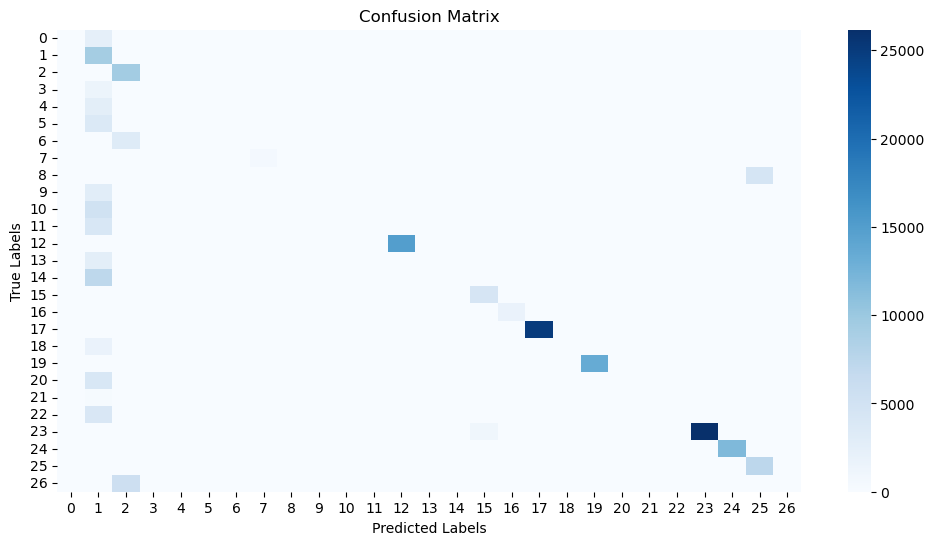

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
y_pred_final = dt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Additional Fix: Ensure All Classes Are in Training Data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)

In [ ]:
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Model Accuracy: 0.68


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       0.00      0.00      0.00      4775
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       0.18      1.00      0.30     18410
                           AEE Aviation Technology G10       0.51      1.00      0.68     18908
                                      Acecore Zetona 8       0.00      0.00      0.00      3033
                      Aerialtronics Altura Zenith ATX8       0.00      0.00      0.00      5377
                       AeroSense Aerobo Wing (AS-VT01)       0.00      0.00      0.00      7543
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       0.00      0.00      0.00      6561
                                          DJI AgrasT20       1.00      1.00      1.00      1110
                                        DJI Matrice100       0.00      0.00      0.00      9150
                                DJI Mat

## Step 4: (Optional) Visualize the Decision Tree

In [ ]:
from sklearn.tree import export_text

# Print decision rules
tree_rules = export_text(dt_model, feature_names=["HazardType", "distance"])
print(tree_rules)

|--- distance <= 1000.02
|   |--- HazardType <= 2.50
|   |   |--- distance <= 100.01
|   |   |   |--- HazardType <= 1.50
|   |   |   |   |--- class: 23
|   |   |   |--- HazardType >  1.50
|   |   |   |   |--- class: 7
|   |   |--- distance >  100.01
|   |   |   |--- class: 23
|   |--- HazardType >  2.50
|   |   |--- class: 23
|--- distance >  1000.02
|   |--- distance <= 4000.00
|   |   |--- distance <= 2000.00
|   |   |   |--- class: 24
|   |   |--- distance >  2000.00
|   |   |   |--- class: 19
|   |--- distance >  4000.00
|   |   |--- distance <= 190000.14
|   |   |   |--- distance <= 52500.14
|   |   |   |   |--- distance <= 7000.01
|   |   |   |   |   |--- class: 25
|   |   |   |   |--- distance >  7000.01
|   |   |   |   |   |--- class: 1
|   |   |   |--- distance >  52500.14
|   |   |   |   |--- distance <= 104607.61
|   |   |   |   |   |--- class: 17
|   |   |   |   |--- distance >  104607.61
|   |   |   |   |   |--- class: 2
|   |   |--- distance >  190000.14
|   |   |   |--- 

In [ ]:
# Fix 1: Increase Tree Depth to Capture More Classes
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42)

In [ ]:
# Get unique predicted classes
predicted_classes = np.unique(y_pred)

# Find labels that exist in test set but were never predicted
missing_labels = set(np.unique(y_test)) - set(predicted_classes)
print(f"Missing predicted labels: {missing_labels}")

Missing predicted labels: {0, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14, 18, 20, 21, 22, 26}


In [ ]:
# Ensure all labels are included in the classification report
print(classification_report(y_test, y_pred, labels=np.unique(y_test), target_names=label_encoder.classes_, zero_division=0))

                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       0.00      0.00      0.00      4775
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       0.18      1.00      0.30     18410
                           AEE Aviation Technology G10       0.51      1.00      0.68     18908
                                      Acecore Zetona 8       0.00      0.00      0.00      3033
                      Aerialtronics Altura Zenith ATX8       0.00      0.00      0.00      5377
                       AeroSense Aerobo Wing (AS-VT01)       0.00      0.00      0.00      7543
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       0.00      0.00      0.00      6561
                                          DJI AgrasT20       1.00      1.00      1.00      1110
                                        DJI Matrice100       0.00      0.00      0.00      9150
                                DJI Mat

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.1, stratify=y_encoded, random_state=42)

In [ ]:
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Model Accuracy: 0.97


C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgisclone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       1.00      1.00      1.00      2388
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       1.00      1.00      1.00      9205
                           AEE Aviation Technology G10       1.00      1.00      1.00      9454
                                      Acecore Zetona 8       0.00      0.00      0.00      1517
                      Aerialtronics Altura Zenith ATX8       0.64      1.00      0.78      2688
                       AeroSense Aerobo Wing (AS-VT01)       0.68      1.00      0.81      3771
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       1.00      1.00      1.00      3281
                                          DJI AgrasT20       1.00      1.00      1.00       555
                                        DJI Matrice100       1.00      1.00      1.00      4575
                                DJI Mat

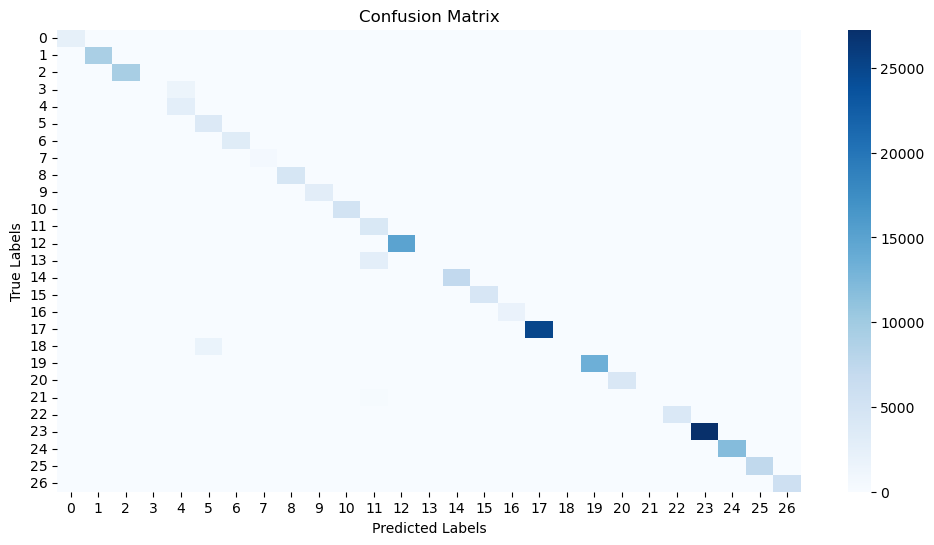

In [ ]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
y_pred_final = dt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred_final)

# Plot confusion matrix
plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(dt_model, X, y_encoded, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validation Accuracy: 0.99 ± 0.01


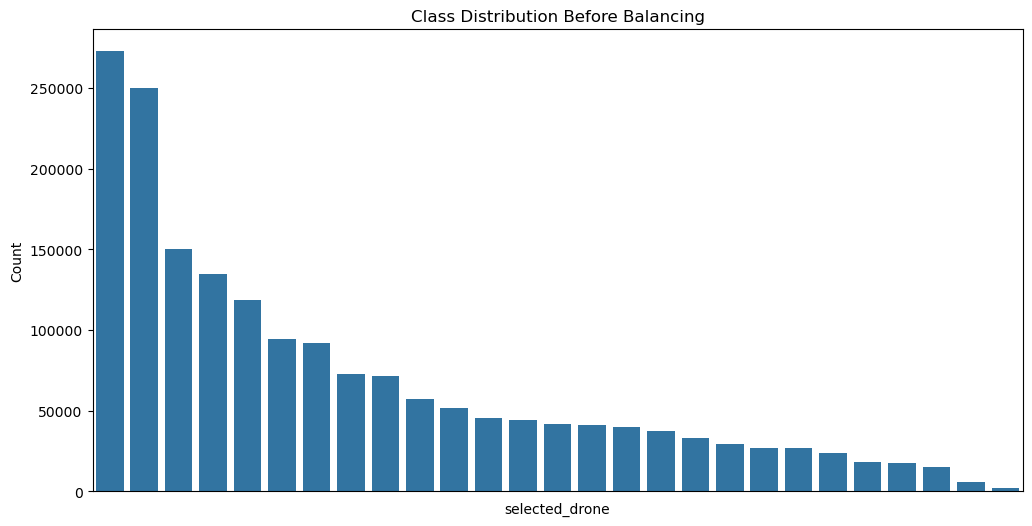

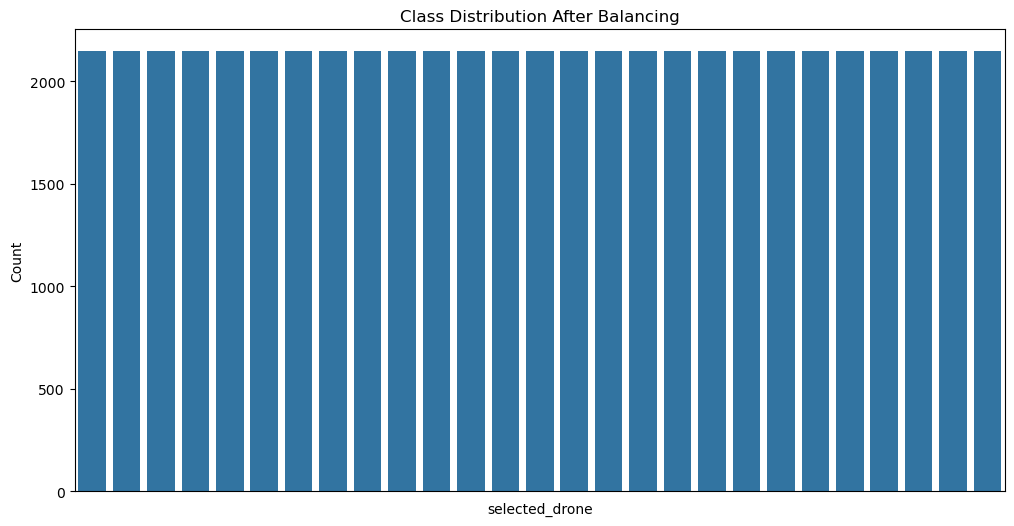

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class distribution before balancing
plt.figure(figsize=(12, 6))
sns.barplot(x=geohazard_df["selected_drone"].value_counts().index,
            y=geohazard_df["selected_drone"].value_counts().values)
plt.xticks([], [])  # Hide x-axis labels for clarity
plt.ylabel("Count")
plt.title("Class Distribution Before Balancing")
plt.show()

# Plot class distribution after balancing (e.g., after SMOTE or downsampling)
plt.figure(figsize=(12, 6))
sns.barplot(x=balanced_df["selected_drone"].value_counts().index,
            y=balanced_df["selected_drone"].value_counts().values)
plt.xticks([], [])  # Hide x-axis labels for clarity
plt.ylabel("Count")
plt.title("Class Distribution After Balancing")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd

# Generate classification report
report = classification_report(y_test, y_pred_final, output_dict=True)

# Convert to DataFrame for visualization
df_report = pd.DataFrame(report).transpose()

# Display classification metrics
import ace_tools as tools
tools.display_dataframe_to_user(name="Classification Report", dataframe=df_report)

In [ ]:
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=15, class_weight="balanced", random_state=42)
dt_model.fit(X_train, y_train)
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Model Accuracy: 1.00
                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       1.00      1.00      1.00      2388
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       1.00      1.00      1.00      9205
                           AEE Aviation Technology G10       1.00      1.00      1.00      9454
                                      Acecore Zetona 8       1.00      1.00      1.00      1517
                      Aerialtronics Altura Zenith ATX8       1.00      1.00      1.00      2688
                       AeroSense Aerobo Wing (AS-VT01)       1.00      1.00      1.00      3771
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       1.00      1.00      1.00      3281
                                          DJI AgrasT20       1.00      1.00      1.00       555
                                        DJI Matrice100       1.00      1.00      1.00      4575
                  

In [ ]:
print(geohazard_df["selected_drone"].value_counts())

selected_drone
IDEAFLY Poseidon-480 Pro II                               272545
Drone America Savant                                      249903
Doosan Mobility Dj25                                      150032
EAMS E484MP                                               134913
IDEAFLY Thor-850                                          118551
AEE Aviation Technology G10                                94538
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection     92052
JTT Spider C85                                             72591
Dragandfly Innovations Inc Starling X.2                    71569
MMC Griflion M8                                            57152
DJI Matrice300RTK                                          51644
DJI Matrice100                                             45751
Drone America Ariel                                        44153
Freespace Operation Callisto 50 Multirotor                 41563
DJI S900                                                   41145
Garuda Rob

In [ ]:
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=10, class_weight="balanced", random_state=42)
dt_model.fit(X_train, y_train)
# Predict on test set
y_pred = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(dt_model, X, y_encoded, cv=5)
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, class_weight="balanced", random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest Accuracy: 0.999950405025624
                                                        precision    recall  f1-score   support

                                         ACSL AirTruck       1.00      1.00      1.00      2388
ACSL PF2-AE Delivery/Disaster-Relief/Patrol/Inspection       1.00      1.00      1.00      9205
                           AEE Aviation Technology G10       1.00      1.00      1.00      9454
                                      Acecore Zetona 8       1.00      1.00      1.00      1517
                      Aerialtronics Altura Zenith ATX8       1.00      1.00      1.00      2688
                       AeroSense Aerobo Wing (AS-VT01)       1.00      1.00      1.00      3771
                    Aerosonde Ltd AAI Aerosonde Mk 4.3       1.00      1.00      1.00      3281
                                          DJI AgrasT20       1.00      1.00      1.00       555
                                        DJI Matrice100       1.00      1.00      1.00      45

In [ ]:
from sklearn.tree import export_text

# Print Decision Tree structure as text
tree_rules = export_text(dt_model, feature_names=["HazardType", "distance"])
print("Decision Tree Structure:")
print(tree_rules)

Decision Tree Structure:
|--- distance <= 29999.90
|   |--- distance <= 26999.88
|   |   |--- distance <= 19999.93
|   |   |   |--- distance <= 18000.06
|   |   |   |   |--- distance <= 15999.97
|   |   |   |   |   |--- distance <= 14999.99
|   |   |   |   |   |   |--- distance <= 12000.03
|   |   |   |   |   |   |   |--- distance <= 8000.00
|   |   |   |   |   |   |   |   |--- distance <= 6999.98
|   |   |   |   |   |   |   |   |   |--- distance <= 4999.99
|   |   |   |   |   |   |   |   |   |   |--- distance <= 4000.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 5
|   |   |   |   |   |   |   |   |   |   |--- distance >  4000.00
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- distance >  4999.99
|   |   |   |   |   |   |   |   |   |   |--- class: 25
|   |   |   |   |   |   |   |   |--- distance >  6999.98
|   |   |   |   |   |   |   |   |   |--- class: 9
|   |   |   |   |   |   |   |--

-----
### ----- Fix Issues -----

### Step 1: Downsample dominant drones to balance the dataset size.

In [ ]:
from sklearn.utils import resample

In [ ]:
# Find the max count for the smallest class
min_class_count = geohazard_df["selected_drone"].value_counts().min()

# Downsample majority classes
balanced_df = geohazard_df.groupby("selected_drone", group_keys=False).apply(lambda x: x.sample(min_class_count, random_state=42))

In [ ]:
# Use SMOTE
from imblearn.over_sampling import SMOTE

In [ ]:
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

In [ ]:
# Train the data Again
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=10, class_weight="balanced", random_state=42)
dt_model.fit(X_train_balanced, y_train_balanced)


# Predict on test set
y_pred_balanced = dt_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# Generate classification report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))